In [48]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import  cross_val_score, KFold, GridSearchCV, RandomizedSearchCV

In [50]:
df = pd.read_csv('/content/9. gurgaon_properties_final.csv', on_bad_lines = 'skip')

df.head()

,property_type,sector,built_up_area,agepossession,bedroom,bathroom,study room,servant room,store room,balcony,furnishing_type,luxury_category,floor_category,price_in_cr
0,flat,Manesar,2233,Moderately Old,4,4,0,0,0,3,Semi-furnished,Low,Mid-rise,0.90
1,house,Sector 48,3229,Moderately Old,4,2,1,1,1,1,Un-furnished,Medium,Low-rise,7.35
2,house,Sector 10A,2367,Moderately Old,4,3,0,0,0,2,Semi-furnished,Low,Low-rise,4.25
3,flat,Sector 81,1300,Relatively New,2,2,0,0,0,3,Semi-furnished,Medium,Mid-rise,0.87
4,flat,Sector 88A,1582,New Property,3,3,0,0,0,3+,Semi-furnished,Medium,High-rise,2.65


In [51]:
df.shape

(3639, 14)

In [52]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

## 1.Power-Transformation on predictor variable

In [103]:
power_trf = PowerTransformer(method='yeo-johnson', standardize = True)

power_trf = power_trf.fit(y.values.reshape(-1, 1))

y_transformed = power_trf.transform(y.values.reshape(-1, 1))

power_trf.lambdas_[0]

-0.7303711985921635

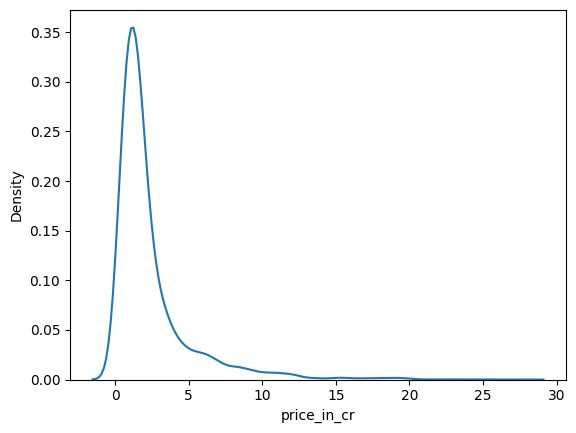

In [54]:
sns.kdeplot(y)
plt.show()

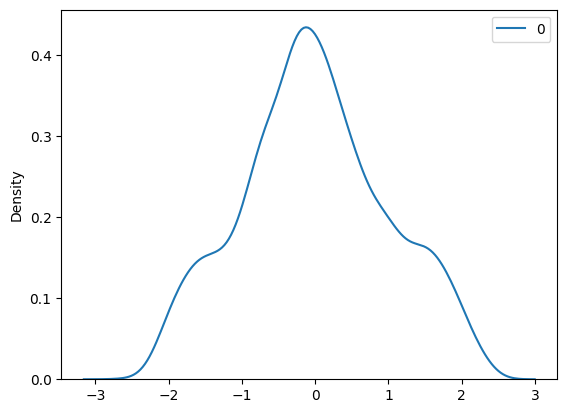

In [55]:
sns.kdeplot(y_transformed)
plt.show()

In [56]:
df.head()

,property_type,sector,built_up_area,agepossession,bedroom,bathroom,study room,servant room,store room,balcony,furnishing_type,luxury_category,floor_category,price_in_cr
0,flat,Manesar,2233,Moderately Old,4,4,0,0,0,3,Semi-furnished,Low,Mid-rise,0.90
1,house,Sector 48,3229,Moderately Old,4,2,1,1,1,1,Un-furnished,Medium,Low-rise,7.35
2,house,Sector 10A,2367,Moderately Old,4,3,0,0,0,2,Semi-furnished,Low,Low-rise,4.25
3,flat,Sector 81,1300,Relatively New,2,2,0,0,0,3,Semi-furnished,Medium,Mid-rise,0.87
4,flat,Sector 88A,1582,New Property,3,3,0,0,0,3+,Semi-furnished,Medium,High-rise,2.65


## 2.Encoding Categorical Variables

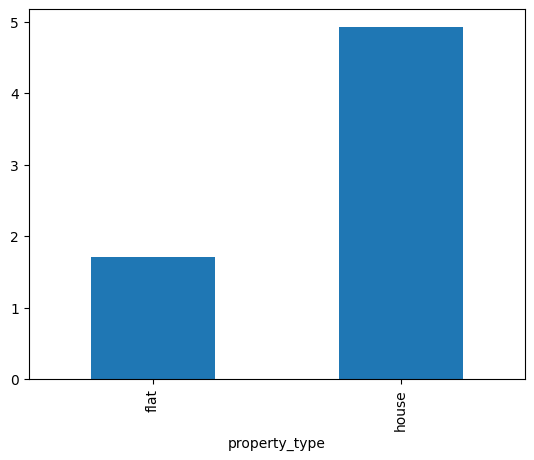

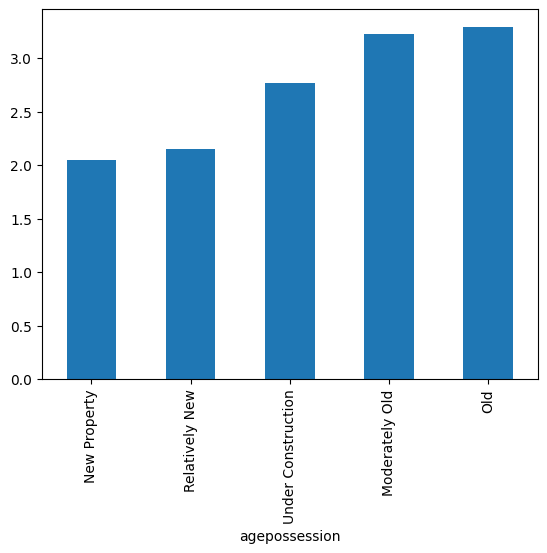

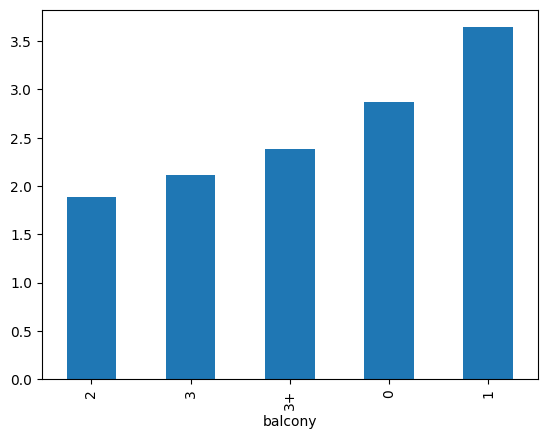

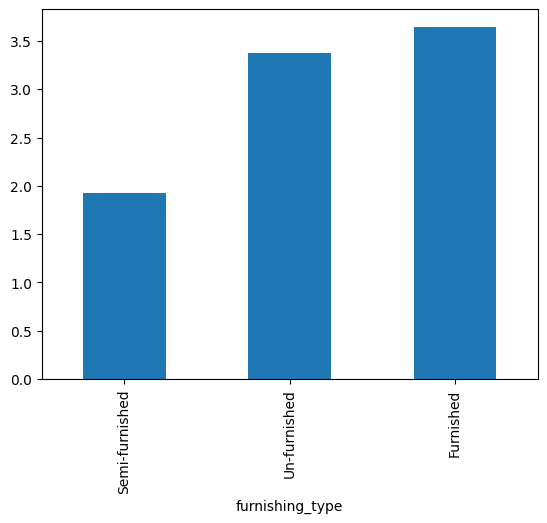

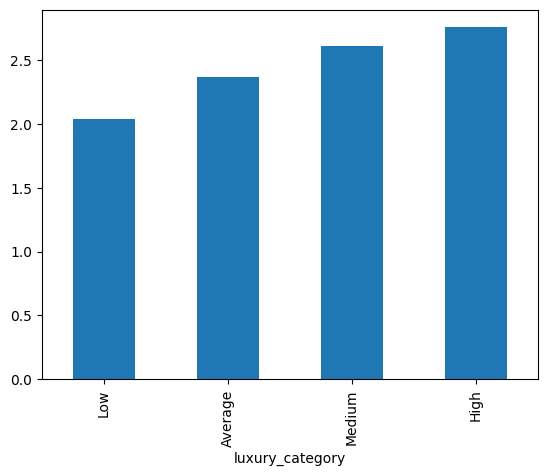

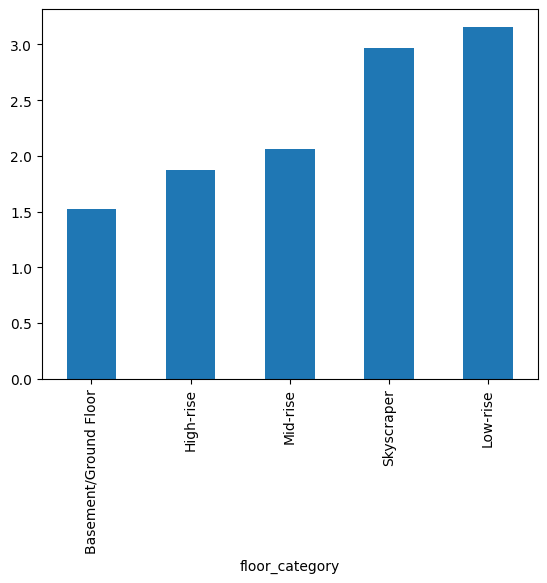

In [57]:
for i in ['property_type', 'agepossession', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']:
    temp = df.groupby(i)['price_in_cr'].mean().sort_values().plot(kind = 'bar')
    plt.show()

In [58]:
ordinal_cols  = ['property_type', 'sector','agepossession', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']

matrix = pd.pivot_table(df, index = 'sector', values = 'price_in_cr', aggfunc = 'mean')

sectors = matrix.sort_values(by = 'price_in_cr', ascending = True).index.tolist()

In [59]:
l1 = ['flat', 'house']
l2 = sectors
l3 = ['New Property', 'Relatively New', 'Under Construction', 'Moderately Old',  'Old' ]
l4 = ['2', '3', '3+', '0', '1']
l5 = ['Semi-furnished', 'Un-furnished', 'Furnished']
l6 = ['Low', 'Average', 'Medium', 'High']
l7 = ['Basement/Ground Floor', 'High-rise', 'Mid-rise','Skyscraper', 'Low-rise']

oe_categories = [l1,l2, l3,l4,l5,l6,l7]

In [60]:
trf_applied = [('ordinal_trf', OrdinalEncoder(categories = oe_categories, dtype = int, handle_unknown = 'use_encoded_value', unknown_value = -1), ordinal_cols)]

encoding_categorical_cols = ColumnTransformer(transformers = trf_applied, remainder = 'passthrough')


## 3.Testing Multiple Models

In [61]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

In [62]:
model_dict = {
    'SVR': SVR(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'LASSO Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators = 200)
}

In [63]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline(steps = [
                   ('categorical_cols', encoding_categorical_cols),
                   ('power_transform_on_all', PowerTransformer(method = 'yeo-johnson', standardize = True)),
                   ('model', model)
                   ])

    # K-fold cross-validation

    kfold = KFold(n_splits = 10, shuffle = True)

    r2 =  np.mean(cross_val_score(pipeline, X, y_transformed, cv = kfold, scoring = 'r2', n_jobs = -1))
    mae = np.mean(cross_val_score(pipeline, X, y_transformed, cv = kfold, scoring = 'neg_mean_absolute_error', n_jobs = -1))

    output.append(r2)  # kfold r2,
    output.append(-mae) # kfold mae

    return output

In [64]:
outputs_data = []

for i, (model_name, model) in enumerate(model_dict.items()):
    outputs_data.append(scorer(model_name, model))

In [65]:
temp = pd.DataFrame(outputs_data, columns = ['name','r2_score','mae']).sort_values(by = ['mae','r2_score'], ascending = [True, False])

temp

,name,r2_score,mae
6,Extra Trees,0.897412,0.216782
5,Random Forest,0.894889,0.222850
7,Gradient Boosting,0.893709,0.239826
0,SVR,0.869824,0.267745
4,Decision Tree,0.804828,0.288705
1,Linear Regression,0.856338,0.289378
2,Ridge Regression,0.855456,0.289800
3,LASSO Regression,-0.002367,0.801754


## 4.Let's Try Hyperparameter Tunining

### RandomizedSearchCV

In [67]:
pipeline = Pipeline(steps = [
                   ('categorical_cols', encoding_categorical_cols),
                   ('power_transform_on_all', PowerTransformer(method = 'yeo-johnson', standardize = True)),
                   ('model', ExtraTreesRegressor())
                   ])

In [68]:
kfold = KFold(n_splits = 10, shuffle = True)

params= {
    'model__n_estimators': [50, 100, 200, 250, 300, 500],
    'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'model__max_features':[0.5, 0.75,'sqrt', 'log2', None],
    'model__max_samples': [0.5, 0.75, 0.85, None],
    'model__bootstrap':[True],
}

In [69]:
rcv = RandomizedSearchCV(pipeline, param_distributions = params, n_iter = 20, scoring = 'r2', cv = kfold, n_jobs = -1, refit = True)

rcv.fit(X, y_transformed)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('categorical_cols',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinal_trf',
                                                                               OrdinalEncoder(categories=[['flat',
                                                                                                           'house'],
                                                                                                          ['Block '
                                                                                                           'A '
                                                                                                           'Sector '
                                                                                                           '21',
                                                                                                           'Sector '
                                                                                                           '11 '
                                                                                                           'Sohna '
                                                                                                           'Road',
                                                                                                           'Surat '
                                                                                                           'Nagar '
                                                                                                           'Phase '
                                                                                                           '2',
                                                                                                           'West '
                                                                                                           'Sector '
                                                                                                           '13',
                                                                                                           'Faridabad '
                                                                                                           'Road',
                                                                                                           'Sect...
                                              PowerTransformer()),
                                             ('model', ExtraTreesRegressor())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True],
                                        'model__criterion': ['squared_error',
                                                             'absolute_error',
                                                             'friedman_mse',
                                                             'poisson'],
                                        'model__max_features': [0.5, 0.75,
                                                                'sqrt', 'log2',
                                                                None],
                                        'model__max_samples': [0.5, 0.75, 0.85,
                                                               None],
                                        'model__n_estimators': [50, 100, 200,
                                                                250, 300,
                                                                500]},
                   scoring='r2')

In [70]:
rcv.best_score_

0.8959592453033356

In [71]:
rcv.best_params_

{'model__n_estimators': 500,
 'model__max_samples': None,
 'model__max_features': None,
 'model__criterion': 'absolute_error',
 'model__bootstrap': True}

### GridSearchCV

In [72]:
kfold = KFold(n_splits = 10, shuffle = True)

params= {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_features':[0.5, 0.75,'sqrt', 'log2', None],
    'model__max_samples': [0.5, 0.75, 0.85, None],
    'model__bootstrap':[True, False],
}

In [73]:
gcv = GridSearchCV(pipeline, param_grid = params, scoring = 'r2', cv = kfold, n_jobs = -1, refit = True)

gcv.fit(X, y_transformed)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('categorical_cols',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal_trf',
                                                                         OrdinalEncoder(categories=[['flat',
                                                                                                     'house'],
                                                                                                    ['Block '
                                                                                                     'A '
                                                                                                     'Sector '
                                                                                                     '21',
                                                                                                     'Sector '
                                                                                                     '11 '
                                                                                                     'Sohna '
                                                                                                     'Road',
                                                                                                     'Surat '
                                                                                                     'Nagar '
                                                                                                     'Phase '
                                                                                                     '2',
                                                                                                     'West '
                                                                                                     'Sector '
                                                                                                     '13',
                                                                                                     'Faridabad '
                                                                                                     'Road',
                                                                                                     'Sector '
                                                                                                     '95...
                                                                          'balcony',
                                                                          'furnishing_type',
                                                                          'luxury_category',
                                                                          'floor_category'])])),
                                       ('power_transform_on_all',
                                        PowerTransformer()),
                                       ('model', ExtraTreesRegressor())]),
             n_jobs=-1,
             param_grid={'model__bootstrap': [True, False],
                         'model__max_features': [0.5, 0.75, 'sqrt', 'log2',
                                                 None],
                         'model__max_samples': [0.5, 0.75, 0.85, None],
                         'model__n_estimators': [100, 200, 300, 500]},
             scoring='r2')

In [74]:
gcv.best_score_

0.8983510368222231

In [75]:
gcv.best_params_

{'model__bootstrap': False,
 'model__max_features': 0.75,
 'model__max_samples': None,
 'model__n_estimators': 500}

## 5.Final Model

In [114]:
pipe = Pipeline(steps=[
                  ('categorical_cols', encoding_categorical_cols),
                  ('power_transform_on_all', PowerTransformer(method='yeo-johnson', standardize=True)),
                  ('model', ExtraTreesRegressor(bootstrap = False, max_features=0.75, max_samples=None, n_estimators=500))
                  ])

In [115]:
kfold = KFold(n_splits = 10, shuffle = True)

r2_score = np.mean(cross_val_score(pipe, X, y_transformed, cv = kfold, scoring = 'r2', n_jobs = -1))

mae = -(np.mean(cross_val_score(pipe, X, y_transformed, cv = kfold, scoring = 'neg_mean_absolute_error', n_jobs = -1)))

print(r2_score, mae)

0.8990066392465279 0.220023727567713


In [131]:
final_pipeline = gcv.best_estimator_

In [133]:
# pipe.fit(X, y_transformed)

In [134]:
pickle.dump(final_pipeline, open('final_model.pkl','wb'))
pickle.dump(power_trf, open('power_trf.pkl','wb'))

## 6.Loading final model

In [135]:
model = pickle.load(open('/content/final_model.pkl','rb'))
model

Pipeline(steps=[('categorical_cols',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_trf',
                                                  OrdinalEncoder(categories=[['flat',
                                                                              'house'],
                                                                             ['Block '
                                                                              'A '
                                                                              'Sector '
                                                                              '21',
                                                                              'Sector '
                                                                              '11 '
                                                                              'Sohna '
                                                                              'Road',
                                                                              'Surat '
                                                                              'Nagar '
                                                                              'Phase '
                                                                              '2',
                                                                              'West '
                                                                              'Sector '
                                                                              '13',
                                                                              'Faridabad '
                                                                              'Road',
                                                                              'Sector '
                                                                              '95',
                                                                              'Samaspur',
                                                                              'Manohar '
                                                                              'Nagar',
                                                                              'Daulatabad',
                                                                              'Sector '
                                                                              '3 '
                                                                              'Phase '
                                                                              '2',
                                                                              'Shanti '
                                                                              'Na...
                                                                              'Floor',
                                                                              'High-rise',
                                                                              'Mid-rise',
                                                                              'Skyscraper',
                                                                              'Low-rise']],
                                                                 dtype=<class 'int'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['property_type', 'sector',
                                                   'agepossession', 'balcony',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category'])])),
                ('power_transform_on_all', PowerTransformer(

In [136]:
power_trf = pickle.load(open('/content/power_trf.pkl','rb'))
power_trf

PowerTransformer()

## 7.Trying out predictions

## Testing 1

In [137]:
df.iloc[0].values

array(['flat', 'Manesar', 2233, 'Moderately Old', 4, 4, 0, 0, 0, '3',
       'Semi-furnished', 'Low', 'Mid-rise', 0.9], dtype=object)

In [138]:
data = [df.iloc[0].values.tolist()[:-1]]

columns = ['property_type', 'sector', 'built_up_area', 'agepossession', 'bedroom', 'bathroom', 'study room', 'servant room',
           'store room', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']

# Convert to DataFrame

one_df = pd.DataFrame(data, columns=columns)

np.round(power_trf.inverse_transform(model.predict(one_df).reshape(-1,1))[0][0],2)

0.9

## Testing 2

In [139]:
df.iloc[1].values

array(['house', 'Sector 48', 3229, 'Moderately Old', 4, 2, 1, 1, 1, '1',
       'Un-furnished', 'Medium', 'Low-rise', 7.35], dtype=object)

In [140]:
data = [df.iloc[1].values.tolist()[:-1]]

columns = ['property_type', 'sector', 'built_up_area', 'agepossession', 'bedroom', 'bathroom', 'study room', 'servant room',
           'store room', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']

# Convert to DataFrame

one_df = pd.DataFrame(data, columns=columns)

np.round(power_trf.inverse_transform(model.predict(one_df).reshape(-1,1))[0][0],2)

7.35

## Testing 3

In [141]:
df.iloc[1500].values

array(['flat', 'Sector 104', 2888, 'Relatively New', 4, 4, 0, 1, 0, '3+',
       'Semi-furnished', 'Low', 'High-rise', 2.65], dtype=object)

In [142]:
data = [df.iloc[1500].values.tolist()[:-1]]

columns = ['property_type', 'sector', 'built_up_area', 'agepossession', 'bedroom', 'bathroom', 'study room', 'servant room',
           'store room', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']

# Convert to DataFrame

one_df = pd.DataFrame(data, columns=columns)

np.round(power_trf.inverse_transform(model.predict(one_df).reshape(-1,1))[0][0],2)

2.65

In [143]:
data = [['flat','Sector 28', 27000, 'New Property', 5, 3, 1, 1, 1, '3+', 'Furnished', 'High', 'High-rise']]

columns = ['property_type', 'sector', 'built_up_area', 'agepossession', 'bedroom', 'bathroom', 'study room', 'servant room',
           'store room', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']

# Convert to DataFrame

one_df = pd.DataFrame(data, columns=columns)

np.round(power_trf.inverse_transform(model.predict(one_df).reshape(-1,1))[0][0],2)

7.42

In [144]:
print(u'\u20B9 {}cr'.format(7.17))

₹ 7.17cr


In [146]:
price = 7.17

lower_value =  price - 0.21
higher_value = price + 0.21

print('The price of this {} is between {} to {}'.format('flat', u'\u20B9 {}cr'.format(np.round(lower_value,3)), u'\u20B9 {}cr'.format(np.round(higher_value,3))))


The price of this flat is between ₹ 6.96cr to ₹ 7.38cr
